In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [9]:
training_df = pd.read_csv("train.csv")

# Exploratory Data Analysis 

In [10]:
training_df.shape

(404290, 6)

In [11]:
training_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
training_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [8]:
training_df["is_duplicate"].value_counts(normalize = True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

#### We see that calss variable consists of 0 for 63% and 1 for 37% of the rows 

Text(0.5, 1.0, 'Distrbution of Class')

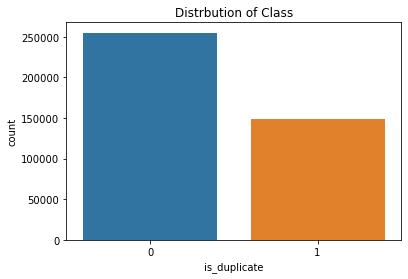

In [23]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
countPlot = sns.countplot(training_df["is_duplicate"], data = training_df)
countPlot.set_title("Distrbution of Class")

In [24]:
#Question Analysis
training_df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [25]:
#converting question 1 and question 2 to string Data Types
training_df["question1"] = training_df["question1"].astype(str)
training_df["question2"] = training_df["question2"].astype(str)

In [26]:
#max length of question 1
max(training_df["question2"].apply(len))

1169

In [27]:
#max length of question 2
max(training_df["question1"].apply(len))

623

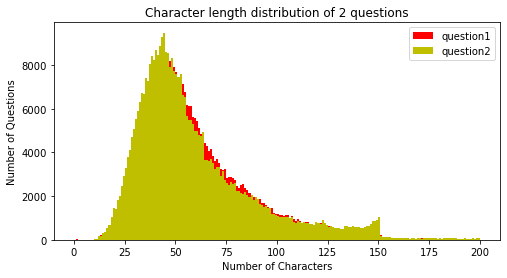

In [28]:
#plotting the character length distribution for question1 and question2 
from matplotlib import pyplot as plt
plt.figure(figsize = (8,4))
plt.hist(training_df["question1"].apply(len), bins = 200, range = [0,200], color = "r")
plt.hist(training_df["question2"].apply(len), bins = 200, range = [0,200], color = "y")
plt.title("Character length distribution of 2 questions")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Questions")
plt.legend(["question1", "question2"])

#### In terms of number of characters, the distributions for both problems are almost the same

In [29]:
#finding the absolute length difference between question1 and question2
question1_length = training_df["question1"].apply(len)
question2_length = training_df["question2"].apply(len)
difference_length = np.abs(question1_length-question2_length)

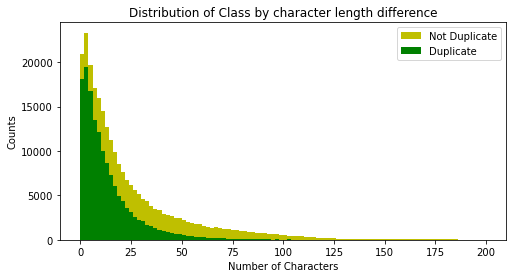

In [30]:
#plotting the absolute length difference based on the class variable values of 0 and 1
plt.figure(figsize = (8,4))
plt.hist(difference_length[training_df["is_duplicate"]==0], bins = 100, color = "y", range = [0,200])
plt.hist(difference_length[training_df["is_duplicate"]==1], bins = 100, color = "g", range = [0,200])
plt.title("Distribution of Class by character length difference")
plt.xlabel("Number of Characters")
plt.ylabel("Counts")
plt.legend(["Not Duplicate", "Duplicate"])

#### For duplicate class the character difference is less 

# Data Cleaning and Root Word Generation:
### Following tasks are done 

1. Cleaning
    a. Lowercase
    b. tokenization
    c. Removing Stopwords
    d. Removing non Alpha numeric characters
2. Lemmatization / Stemming
3. Dividing into training (95%) and test set(5%)


In [13]:
english_stopwords = stopwords.words("english")
print(stopwords.words("english"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
#data_cleaning method to remove stop words
def data_cleaning(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [i for i in words if i not in english_stopwords and i.isalnum()]
    return words

In [33]:
#using the data cleaning method to filter question1 and question2
q1 = training_df["question1"].apply(data_cleaning)
q2 = training_df["question2"].apply(data_cleaning)

In [34]:
q1.head(5)

0    [step, step, guide, invest, share, market, india]
1                           [story, kohinoor, diamond]
2    [increase, speed, internet, connection, using,...
3                            [mentally, lonely, solve]
4    [one, dissolve, water, quikly, sugar, salt, me...
Name: question1, dtype: object

In [35]:
q2.head(5)

0           [step, step, guide, invest, share, market]
1    [would, happen, indian, government, stole, koh...
2           [internet, speed, increased, hacking, dns]
3                 [find, remainder, math, 24, divided]
4                  [fish, would, survive, salt, water]
Name: question2, dtype: object

In [36]:
#Method to create lemmatized words using WordNetLemmatizer of nltk package
lemmatizer = WordNetLemmatizer()
def lemmatized_words(text):
    return " ".join([lemmatizer.lemmatize(i) for i in text])

In [37]:
q1_lemmatized = q1.apply(lemmatized_words)
q2_lemmatized = q2.apply(lemmatized_words) 

In [38]:
q1_lemmatized.head(5)

0            step step guide invest share market india
1                               story kohinoor diamond
2         increase speed internet connection using vpn
3                                mentally lonely solve
4    one dissolve water quikly sugar salt methane c...
Name: question1, dtype: object

In [39]:
q2_lemmatized.head(5)

0                  step step guide invest share market
1    would happen indian government stole kohinoor ...
2                 internet speed increased hacking dns
3                       find remainder math 24 divided
4                        fish would survive salt water
Name: question2, dtype: object

In [40]:
#Method to create stemmed words using PorterStemmer of nltk package
stemmer = PorterStemmer()
def stemming_words(text):
    return " ".join([stemmer.stem(i) for i in text]) 

In [41]:
q1_stemmed = q1.apply(stemming_words)
q2_stemmed = q2.apply(stemming_words)

In [42]:
q1_stemmed.head(5)

0             step step guid invest share market india
1                               stori kohinoor diamond
2               increas speed internet connect use vpn
3                                     mental lone solv
4    one dissolv water quikli sugar salt methan car...
Name: question1, dtype: object

In [52]:
q2_stemmed.head(5)


0                   step step guid invest share market
1    would happen indian govern stole kohinoor diam...
2                       internet speed increas hack dn
3                           find remaind math 24 divid
4                         fish would surviv salt water
Name: question2, dtype: object

In [53]:
#splitting the data into train and test with 95% being train and 5% test data
#using the random seed to split the data
seed = 37187892
iv_train , iv_test, cv_train, cv_test = train_test_split(np.arange(0,training_df.shape[0]), training_df["is_duplicate"], train_size = 0.95, stratify = training_df["is_duplicate"], random_state = seed)

In [54]:
#getting the corresponding questions data using iloc method
ds_clean = pd.DataFrame({"q1":q1_stemmed, "q2":q2_stemmed})
ds_clean.to_csv("d_clean_new.csv", index = False)
ds_train, ds_test = ds_clean.iloc[iv_train, :], ds_clean.iloc[iv_test, :]

In [55]:
ds_train.head(5)

,q1,q2
31326,small town indian dropout colleg follow passio...,end go mediocr colleg affect option master abroad
302555,evid conscious surviv death,tangibl evid life death
262996,differ cast religion,fact indian templ
323785,handicap passion comput web current work junio...,think late start program want get junior web d...
253533,phone buy inr 15k,good smartphon 15k


In [56]:
#finding the difference of length of questions for train and test sets
diff_length_train = difference_length[iv_train]
diff_length_test = difference_length[iv_test]

# Character Counts

In [57]:
ques_train = pd.concat([ds_train["q1"], ds_train["q2"]], axis = 0)

In [58]:
ques_train.head(5)

31326     small town indian dropout colleg follow passio...
302555                          evid conscious surviv death
262996                                 differ cast religion
323785    handicap passion comput web current work junio...
253533                                    phone buy inr 15k
dtype: object

In [60]:
#Using countvectorizer to form counts of repeated words and ngrams of 2 to 6
counts_vector = CountVectorizer(analyzer = "char", ngram_range = (2,6))
counts_vector.fit(ques_train);

In [61]:
counts_vector.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='char', ngram_range=(2, 6))>

In [62]:
char_q1_train = counts_vector.transform(ds_train["q1"])
char_q2_train = counts_vector.transform(ds_train["q2"])
char_q1_test = counts_vector.transform(ds_test["q1"])
char_q2_test = counts_vector.transform(ds_test["q2"])

# Cosine Similarity

In [64]:
# method to find cosine similarity between 2 vectors using sklearn cosine_similarity method
def cos_sim(vector1, vector2):
    cosine_sim = np.empty([vector1.shape[0], 1])
    for i,v in enumerate(zip(vector1, vector2)):
        cosine_sim[i] = (float(cosine_similarity(v[0], v[1])))
    return cosine_sim

In [65]:
# cosine similarity for training data
cosine_sim_train = cos_sim(char_q1_train, char_q2_train)

In [66]:
# cosine similarity for testing data
cosine_sim_test = cos_sim(char_q1_test, char_q2_test)

# Combining Features & Normalizing
Combine diff_len and cos_sim with char counts as 2 feature for the model
Normalize using min max scaler

In [67]:
features_train = pd.DataFrame({"diff_len": diff_length_train, "cos_sim": list(cosine_sim_train)})
features_test = pd.DataFrame({"diff_len": diff_length_test, "cos_sim": list(cosine_sim_test)})

In [68]:
scaler = MinMaxScaler()
scaler.fit(features_train)
features_train_new = scaler.transform(features_train)
features_test_new = scaler.transform(features_test)

# Modeling
## Logistic Regression

In [117]:
cosine_summary = pd.DataFrame(columns = ["Model Type using Diff_len & Char_counts",
                                         "Log Loss Score","Accuracy Score"])

In [118]:
lr_model = LogisticRegression()
lr_model.fit(features_train_new , cv_train)
predictions_train = lr_model.predict_proba(features_train_new)[:,1];

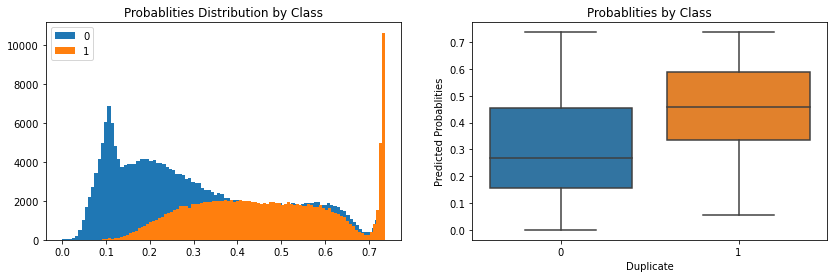

In [119]:
fig, img = plt.subplots(1,2, figsize = (14,4))
img[0].hist(predictions_train[cv_train==0], bins = 100)
img[0].hist(predictions_train[cv_train==1], bins = 100)
img[0].set_title("Probablities Distribution by Class")
img[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_predictions":predictions_train, "y":cv_train})
sns.boxplot(x="y", y="LR_predictions", data = output_lr, ax = img[1])
img[1].set_ylabel("Predicted Probablities")
img[1].set_xlabel("Duplicate")
img[1].set_title("Probablities by Class");

In [120]:
predictions_test = lr_model.predict_proba(features_test_new)[:,1]
log_loss_score = log_loss(cv_test, predictions_test)
accuracy = lr_model.score(features_test_new, cv_test)

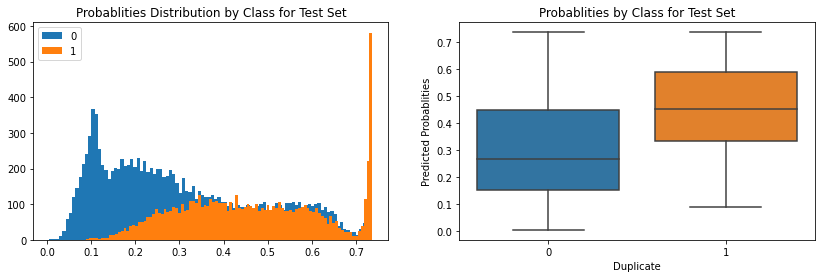

In [121]:
fig, img = plt.subplots(1,2, figsize = (14,4))
img[0].hist(predictions_test[cv_test==0], bins = 100)
img[0].hist(predictions_test[cv_test==1], bins = 100)
img[0].set_title("Probablities Distribution by Class for Test Set")
img[0].legend(["0","1"])

output_lr = pd.DataFrame({"LR_predictions":predictions_test, "y":cv_test})
sns.boxplot(x="y", y="LR_predictions", data = output_lr, ax = img[1])
img[1].set_ylabel("Predicted Probablities")
img[1].set_xlabel("Duplicate")
img[1].set_title("Probablities by Class for Test Set");


In [122]:
cosine_summary  = cosine_summary.append({"Model Type using Diff_len & Char_counts":"Logistic Regression", "Log Loss Score":np.round(log_loss_score,4), "Accuracy Score":np.round(accuracy,4)}, ignore_index = True)


In [123]:
cosine_summary

,Model Type using Diff_len & Char_counts,Log Loss Score,Accuracy Score
0,Logistic Regression,0.5715,0.6571


## Random Forest

In [124]:
rf_model = RandomForestClassifier(max_depth = 8, n_estimators = 700)
rf_model.fit(features_train_new , cv_train)
predictions_train = rf_model.predict_proba(features_train_new)[:,1];

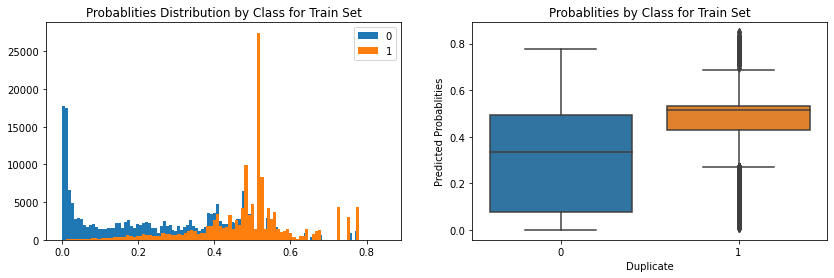

In [125]:
fig, img = plt.subplots(1,2, figsize = (14,4))
img[0].hist(predictions_train[cv_train==0], bins = 100)
img[0].hist(predictions_train[cv_train==1], bins = 100)
img[0].set_title("Probablities Distribution by Class for Train Set")
img[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_predictions":predictions_train, "y":cv_train})
sns.boxplot(x="y", y="LR_predictions", data = preds_labels, ax = img[1])
img[1].set_ylabel("Predicted Probablities")
img[1].set_xlabel("Duplicate")
img[1].set_title("Probablities by Class for Train Set");

In [126]:
predictions_test = rf_model.predict_proba(features_test_new)[:,1]
log_loss_score = log_loss(cv_test, predictions_test)
accuracy = rf_model.score(features_test_new, cv_test)

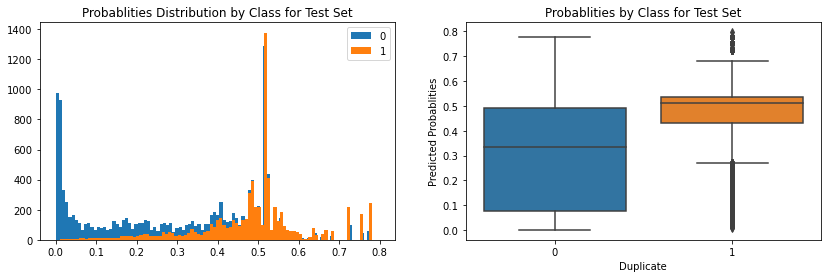

In [127]:
fig, img = plt.subplots(1,2, figsize = (14,4))
img[0].hist(predictions_test[cv_test==0], bins = 100)
img[0].hist(predictions_test[cv_test==1], bins = 100)
img[0].set_title("Probablities Distribution by Class for Test Set")
img[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_predictions":predictions_test, "y":cv_test})
sns.boxplot(x="y", y="LR_predictions", data = preds_labels, ax = img[1])
img[1].set_ylabel("Predicted Probablities")
img[1].set_xlabel("Duplicate")
img[1].set_title("Probablities by Class for Test Set");

In [128]:
cosine_summary  = cosine_summary.append({"Model Type using Diff_len & Char_counts":"Random Forest", "Log Loss Score":np.round(log_loss_score,4), "Accuracy Score":np.round(accuracy,4)}, ignore_index = True)

In [129]:
cosine_summary

,Model Type using Diff_len & Char_counts,Log Loss Score,Accuracy Score
0,Logistic Regression,0.5715,0.6571
1,Random Forest,0.5422,0.6792


#### XGBoost

In [130]:
xgb_model = XGBClassifier(max_depth = 4, n_estimators = 500)
xgb_model.fit(features_train_new , cv_train)
predictions_train = xgb_model.predict_proba(features_train_new)[:,1];

/Users/saikiranbatchu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:48:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


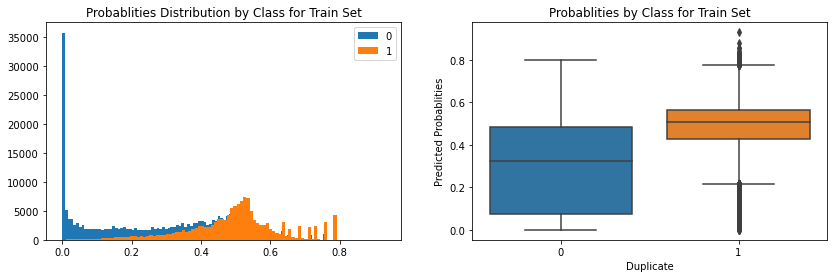

In [131]:
fig, img = plt.subplots(1,2, figsize = (14,4))
img[0].hist(predictions_train[cv_train==0], bins = 100)
img[0].hist(predictions_train[cv_train==1], bins = 100)
img[0].set_title("Probablities Distribution by Class for Train Set")
img[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_predictions":predictions_train, "y":cv_train})
sns.boxplot(x="y", y="LR_predictions", data = preds_labels, ax = img[1])
img[1].set_ylabel("Predicted Probablities")
img[1].set_xlabel("Duplicate")
img[1].set_title("Probablities by Class for Train Set");

In [132]:
predictions_test = xgb_model.predict_proba(features_test_new)[:,1]
log_loss_score = log_loss(cv_test, predictions_test)
accuracy = xgb_model.score(features_test_new, cv_test)

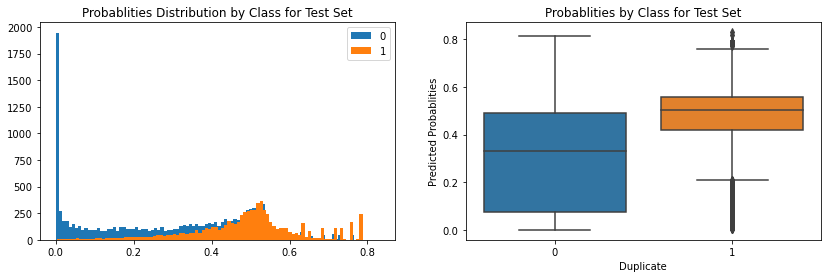

In [133]:
fig, img = plt.subplots(1,2, figsize = (14,4))
img[0].hist(predictions_test[cv_test==0], bins = 100)
img[0].hist(predictions_test[cv_test==1], bins = 100)
img[0].set_title("Probablities Distribution by Class for Test Set")
img[0].legend(["0","1"])

preds_labels = pd.DataFrame({"LR_predictions":predictions_test, "y":cv_test})
sns.boxplot(x="y", y="LR_predictions", data = preds_labels, ax = img[1])
img[1].set_ylabel("Predicted Probablities")
img[1].set_xlabel("Duplicate")
img[1].set_title("Probablities by Class for Test Set");


In [134]:
cosine_summary  = cosine_summary.append({"Model Type using Diff_len & Char_counts":"XGBoost", "Log Loss Score":np.round(log_loss_score,4), "Accuracy Score":np.round(accuracy,4)}, ignore_index = True)


In [135]:
cosine_summary

,Model Type using Diff_len & Char_counts,Log Loss Score,Accuracy Score
0,Logistic Regression,0.5715,0.6571
1,Random Forest,0.5422,0.6792
2,XGBoost,0.5404,0.6791


# Using Grid Search to find the best hyperparameters for XGBoost

used the concept and code explained in the link https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
    

### Using n_estimators = [50, 100, 150, 200] and max_depth = [4, 5, 6]

[4, 5, 6]
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[23:07:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.543134 using {'max_depth': 4, 'n_estimators': 200}
-0.543898 (0.001541) with: {'max_depth': 4, 'n_estimators': 50}
-0.543516 (0.001577) with: {'max_depth': 4, 'n_estimators': 100}
-0.543291 (0.001611) with: {'max_depth': 4, 'n_estimators': 150}
-0.543134 (0.001645) with: {'max_depth': 4, 'n_estimators': 200}
-0.543708 (0.001669) with: {'max_depth': 5, 'n_estimators': 50}
-0.543419 (0.001605) with: {'max_depth': 5, 'n_estimators': 100}
-0.543307 (0.001571) with: {'max_depth': 5, 'n_estimators': 150}
-0.543243 (0.001713) with: {'max_depth': 5, 'n_estimators': 200}
-0.543569 (0.001611) with: {'max_depth': 6, 'n_estimators': 50}
-0.543383 (0.001631) with: {'max_

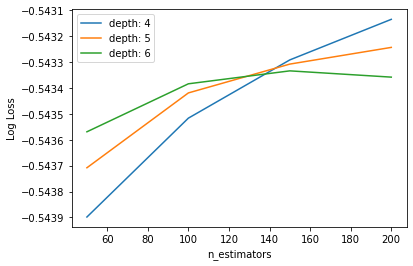

In [136]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
model = XGBClassifier(use_label_encoder=False)
n_estimators = [50, 100, 150, 200]
max_depth = [4, 5, 6]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(features_train_new, cv_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')

#### found that max_depth': 4, 'n_estimators': 200 and yielded better logloss value

### Using n_estimators = [150, 200, 250, 300, 500] and max_depth = [4]

[4]
Fitting 10 folds for each of 5 candidates, totalling 50 fits
[16:24:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.543016 using {'max_depth': 4, 'n_estimators': 500}
-0.543291 (0.001611) with: {'max_depth': 4, 'n_estimators': 150}
-0.543134 (0.001645) with: {'max_depth': 4, 'n_estimators': 200}
-0.543118 (0.001620) with: {'max_depth': 4, 'n_estimators': 250}
-0.543059 (0.001654) with: {'max_depth': 4, 'n_estimators': 300}
-0.543016 (0.001703) with: {'max_depth': 4, 'n_estimators': 500}


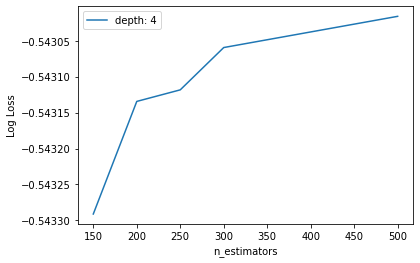

In [75]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
model = XGBClassifier(use_label_encoder=False)
n_estimators = [150, 200, 250, 300, 500]
max_depth = [4]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(features_train_new, cv_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth for 4.png')

Found that estimators of 500 is giving the best log loss value

### Using n_estimators = [500, 1000, 1500] and max_depth = [4]

[4]
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[16:41:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.543016 using {'max_depth': 4, 'n_estimators': 500}
-0.543016 (0.001703) with: {'max_depth': 4, 'n_estimators': 500}
-0.543670 (0.001669) with: {'max_depth': 4, 'n_estimators': 1000}
-0.544403 (0.001727) with: {'max_depth': 4, 'n_estimators': 1500}


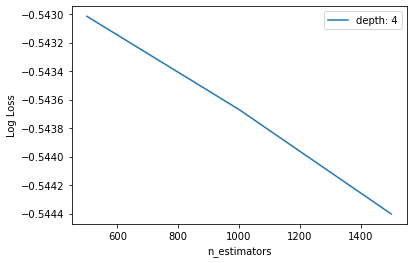

[16:17:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[16:17:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:19:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [76]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
model = XGBClassifier(use_label_encoder=False)
n_estimators = [500, 1000, 1500]
max_depth = [4]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(features_train_new, cv_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth for 4.png')

Found that upon training with n_estimators more than 500 the model is getting overfit impacting the value of logloss

# Using Grid Search to find the best hyperparameters for Random Forest

### Using n_estimators = [100,200] and max_depth = [4,5,6]

[4, 5, 6]
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best: -0.546832 using {'max_depth': 6, 'n_estimators': 200}
-0.554293 (0.001398) with: {'max_depth': 4, 'n_estimators': 100}
-0.554306 (0.001731) with: {'max_depth': 4, 'n_estimators': 200}
-0.549592 (0.001432) with: {'max_depth': 5, 'n_estimators': 100}
-0.549835 (0.001511) with: {'max_depth': 5, 'n_estimators': 200}
-0.546986 (0.001586) with: {'max_depth': 6, 'n_estimators': 100}
-0.546832 (0.001712) with: {'max_depth': 6, 'n_estimators': 200}


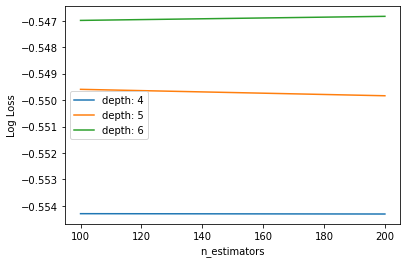

In [77]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
from sklearn.ensemble import RandomForestClassifier
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
#model = XGBClassifier(use_label_encoder=False)
model = RandomForestClassifier()
n_estimators = [100,200]
max_depth = [4,5,6]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(features_train_new, cv_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth for 4.png')

Found that max_depth': 6, 'n_estimators': 200 gave the best log loss value

### Using n_estimators = [200, 300, 500 ,700, 1000] and max_depth = [6]

[6]
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: -0.546819 using {'max_depth': 6, 'n_estimators': 700}
-0.546926 (0.001545) with: {'max_depth': 6, 'n_estimators': 200}
-0.546956 (0.001640) with: {'max_depth': 6, 'n_estimators': 300}
-0.546898 (0.001675) with: {'max_depth': 6, 'n_estimators': 500}
-0.546819 (0.001599) with: {'max_depth': 6, 'n_estimators': 700}
-0.546862 (0.001659) with: {'max_depth': 6, 'n_estimators': 1000}


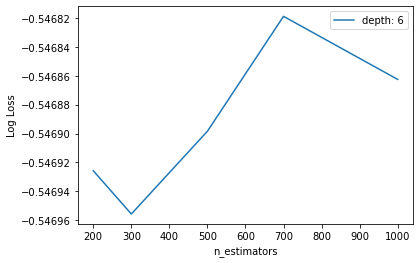

In [78]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
from sklearn.ensemble import RandomForestClassifier
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
#model = XGBClassifier(use_label_encoder=False)
model = RandomForestClassifier()
n_estimators = [200, 300, 500 ,700, 1000]
max_depth = [6]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(features_train_new, cv_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth for 4.png')

[5, 6, 7, 8]
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best: -0.544588 using {'max_depth': 8, 'n_estimators': 700}
-0.549733 (0.001577) with: {'max_depth': 5, 'n_estimators': 700}
-0.546908 (0.001641) with: {'max_depth': 6, 'n_estimators': 700}
-0.545369 (0.001691) with: {'max_depth': 7, 'n_estimators': 700}
-0.544588 (0.001671) with: {'max_depth': 8, 'n_estimators': 700}


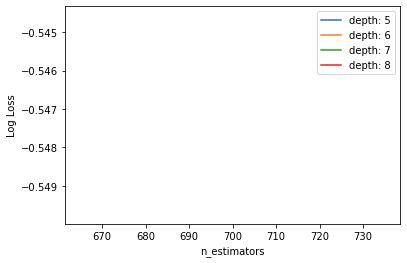

In [79]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib
from sklearn.ensemble import RandomForestClassifier
matplotlib.use('Agg')
from matplotlib import pyplot
import numpy
#model = XGBClassifier(use_label_encoder=False)
model = RandomForestClassifier()
n_estimators = [700]
max_depth = [5, 6, 7, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(features_train_new, cv_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = numpy.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth for 4.png')

#### at max_depth': 8, 'n_estimators': 700 we got the best log loss value